#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit 

#### Load Data

In [2]:
PATH="output/random_text/info"
compressor_table = {
    "gz": "gzip",
    "bz2": "bzip2",
    "lzma": "lzma",
    "zst": "zstd",
    "paq8n": "paq8",
    "nncp": "nncp",
    "mfc": "MFCompress",
    "naf": "naf",
    "spr": "spring",
    "tar": "JARVIS3"
}

def load_data(file_type):
    df = pd.DataFrame()
    for filename in os.listdir(f"output/{file_type}/info"):
        compressor = filename.split("_")[0]
        filesize = filename.split("_")[1].split(".")[0]

        tmp = pd.read_csv(f"output/{file_type}/info/{filename}")
        tmp["compressor"] = compressor
        tmp["filesize"] = filesize

        if os.path.exists(f"output/{file_type}/decompression_results/{filename}"):
            tmp2 = pd.read_csv(f"output/{file_type}/decompression_results/{filename}")
            tmp2.rename(columns={
                "task-clock": "dtask-clock",
                "cycles": "dcycles",
                "instructions": "dinstructions",
                "time-elapsed": "dtime-elapsed",
            }, inplace=True)
            tmp2["compressor"] = compressor
            tmp2["filesize"] = filesize
            tmp = pd.merge(tmp, tmp2, on=["compressor", "filesize"])
            df = pd.concat([df, tmp])
        else:


            df = pd.concat([df, tmp])

    for filename in os.listdir(f"output/{file_type}/compressed_files"):
        suffix = filename.split(".")[-1]
        compressor = compressor_table[suffix]
        filesize = filename.split(".")[0]
        # print(filename, os.path.getsize(f"output/{file_type}/compressed_files/{filename}"))
        comp_size = os.path.getsize(f"output/{file_type}/compressed_files/{filename}")

        # Add compressed_size column to df
        df.loc[(df["compressor"]==compressor) & (df["filesize"]==filesize), "compressed_size"] = comp_size
    return df


In [3]:
def plot_stat(df: pd.DataFrame, decompression=False, log=True):
    titles = [
        "Time elapsed (s)",
        "Nº of instructions",
        "Nº of cycles",
    ]
    columns = [
        "time-elapsed",
        "instructions",
        "cycles",
    ]
    if decompression:
        columns = [
            "dtime-elapsed",
            "dinstructions",
            "dcycles",
        ]

    plot_layouts = [0,1,2]

    compressors = df["compressor"].unique()
    tmp = df.groupby(["compressor", "filesize"]).mean().reset_index()
    tmp = df.groupby(["compressor", "filesize"]).mean().reset_index().reindex(index=tmp.index[::-1])
    tmp["filesize"] = tmp["filesize"].apply(lambda x: int(x.split("Mb")[0]))
    tmp.sort_values(by="filesize", inplace=True)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for title, column, x in zip(titles, columns, plot_layouts):
        for compressor in compressors:
            # check if column as values
            if tmp[tmp["compressor"] == compressor][column].isnull().all():
                continue

            ax[x].plot(
                tmp[tmp["compressor"] == compressor]["filesize"],
                tmp[tmp["compressor"] == compressor][column],
                label=compressor,
                marker="o",
            )
        ax[x].set_xlabel("Filesize (MB)")
        ax[x].set_ylabel(title)
        ax[x].legend()
        if log:
            ax[x].set_yscale("log")
            ax[x].set_xscale("log")
        #ax[x].set_title(title)



In [4]:
def plot_compressed_size(df: pd.DataFrame, filesizes=[]):
    
    if not filesizes:
        filesizes =["1Mb", "10Mb", "100Mb", "1000Mb"]

    plot_layouts = [(0,0), (0,1), (1,0), (1,1)]

    # make plot larger


    fig, ax = plt.subplots(2, 2, figsize=(12, 12))

    for filesize, plot_layout in zip(filesizes, plot_layouts):
        # for compressor in compressors:
        #     comp_size = df[(df["compressor"]==compressor) & (df["filesize"]==filesize)]["compressed_size"].values[0]
        #     print(f"{compressor} - {filesize}: {comp_size} bytes")

        # sort bar plot by compressed size
        tmp = df.sort_values(by=["filesize", "compressed_size"])
        x, y = plot_layout

        ax[x, y].bar(
            tmp[tmp["filesize"]==filesize]["compressor"],
            tmp[tmp["filesize"]==filesize]["compressed_size"]
        )
        # add bar with original size
        # ax[x, y].axhline(
        #     y=1_000_000*int(filesize.split("Mb")[0]), 
        #     color="red", 
        #     linestyle="--", 
        #     label="Original size"
        # )

        # get minimum compressed size
        min_size = tmp[tmp["filesize"]==filesize]["compressed_size"].min()
        max_size = tmp[tmp["filesize"]==filesize]["compressed_size"].max()


        filesize1 = int(filesize.split("Mb")[0])*1_000_000

        # make scale smaller
        ax[x, y].set_ylim(min_size-filesize1*0.01, max_size+filesize1*0.01)


        ax[x, y].set_ylabel("Compressed size (bytes)")
        ax[x, y].set_xlabel("Compressor")
        ax[x, y].set_title(f"Compressed size for {filesize} files")
        # y axis in scientific notation
        ax[x, y].ticklabel_format(style='sci', axis='y', scilimits=(0,0))



    
    

In [5]:
def box_plot(df: pd.DataFrame, without_first=False):


    compressors = df["compressor"].unique()
    tmp = df.groupby(["compressor", "filesize"]).mean().reset_index()
    if without_first:
        tmp = tmp[tmp["filesize"]!="1Mb"]

    data = []
    for compresor in compressors:
        data.append(
            [
                int(fsize.split("Mb")[0])/(compsize/1_000_000) 
                for fsize, compsize in 
                    zip(tmp[tmp["compressor"]==compresor]["filesize"], 
                        tmp[tmp["compressor"]==compresor]["compressed_size"]
                    )
            ]
        )

    fig, ax = plt.subplots()
    ax.boxplot(data, labels=compressors)
    ax.set_ylabel("Compression ratio")
    ax.set_xlabel("Compressor")

## Random Text Files

In [13]:
df = load_data("random_text")
df.head()


,task-clock,cycles,instructions,time-elapsed,compressor,filesize,dtask-clock,dcycles,dinstructions,dtime-elapsed,compressed_size
0,211.86,818500889,1000166135,0.212468,lzma,1Mb,27.80,101534595.0,222982297.0,0.028406,773567.0
1,211.86,818500889,1000166135,0.212468,lzma,1Mb,27.45,103395802.0,227890055.0,0.027852,773567.0
2,211.86,818500889,1000166135,0.212468,lzma,1Mb,28.41,103041619.0,223329928.0,0.028989,773567.0
3,211.86,818500889,1000166135,0.212468,lzma,1Mb,27.80,100412518.0,222765532.0,0.028896,773567.0
4,211.86,818500889,1000166135,0.212468,lzma,1Mb,28.03,103247883.0,225821479.0,0.028440,773567.0


In [6]:
# show compressor nncp
df[df["compressor"]=="zstd"]

,task-clock,cycles,instructions,time-elapsed,compressor,filesize,compressed_size
0,28.83,57216944,134385195,0.022366,zstd,10Mb,7576540.0
1,25.46,75691275,146799187,0.020372,zstd,10Mb,7576540.0
2,27.19,54101445,124685290,0.021382,zstd,10Mb,7576540.0
3,25.63,47179899,132556342,0.019954,zstd,10Mb,7576540.0
4,27.77,74470582,127741920,0.021873,zstd,10Mb,7576540.0
0,4.83,2077069,16810008,0.004436,zstd,1Mb,757685.0
1,5.57,2355227,16584880,0.004688,zstd,1Mb,757685.0
2,8.14,1635222,16063668,0.007338,zstd,1Mb,757685.0
3,4.42,1673854,16811837,0.003969,zstd,1Mb,757685.0
4,4.57,3365788,16812508,0.004148,zstd,1Mb,757685.0


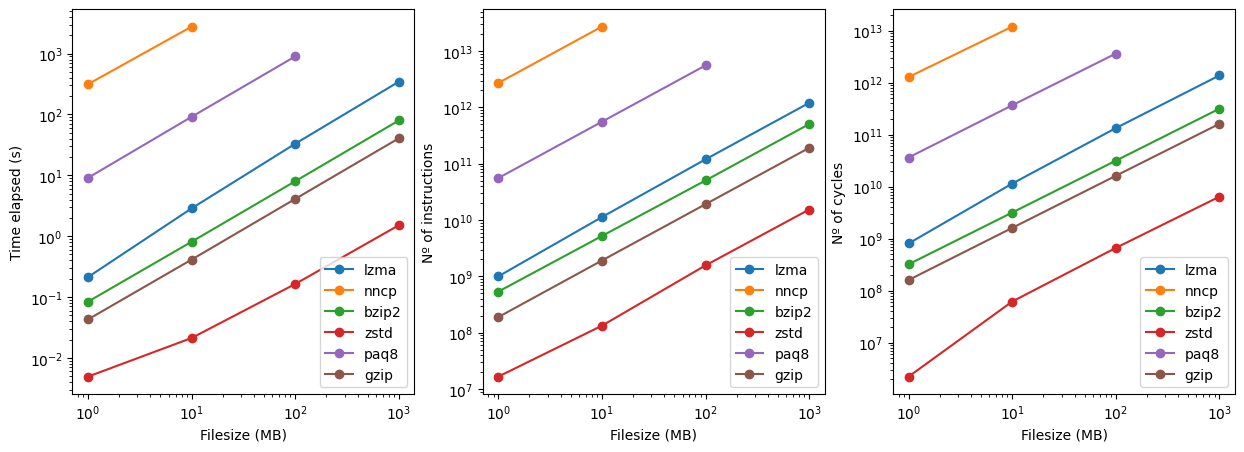

In [14]:
plot_stat(df)

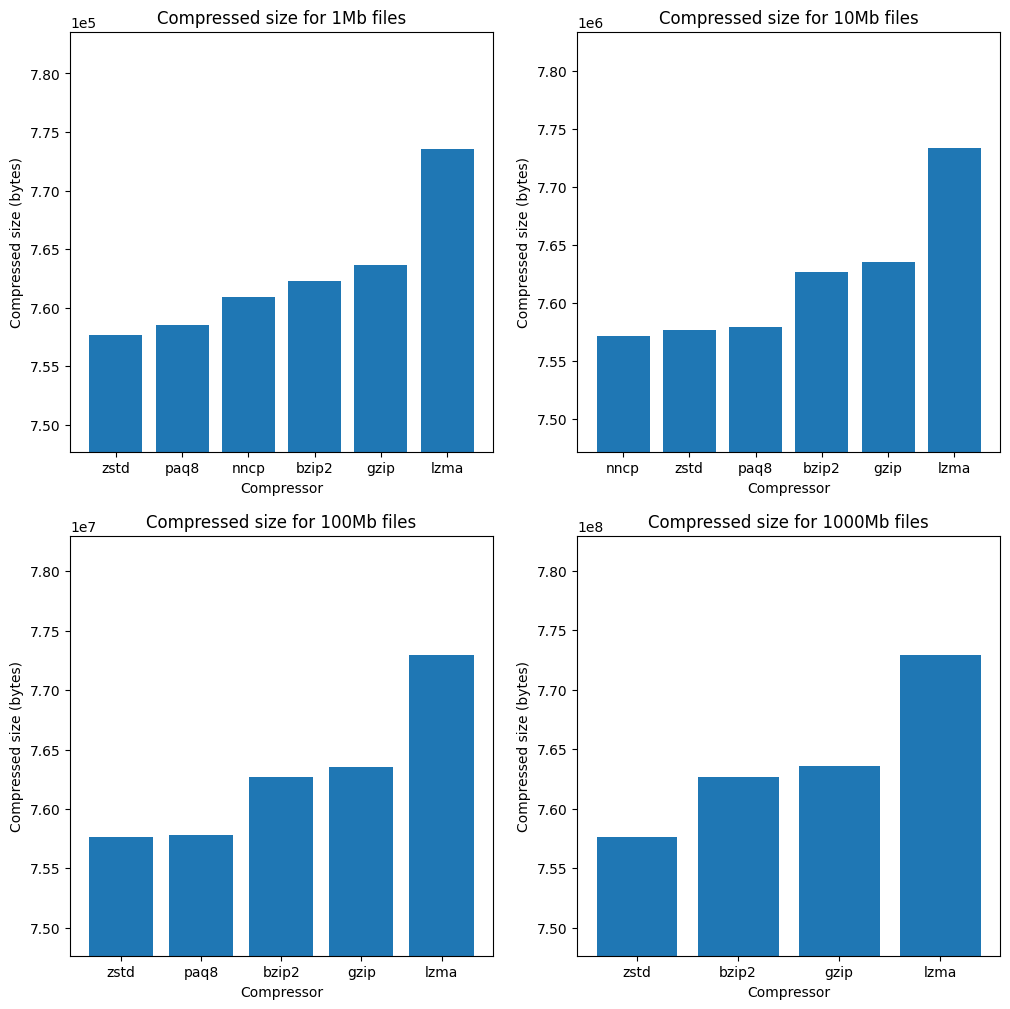

In [8]:
plot_compressed_size(df)

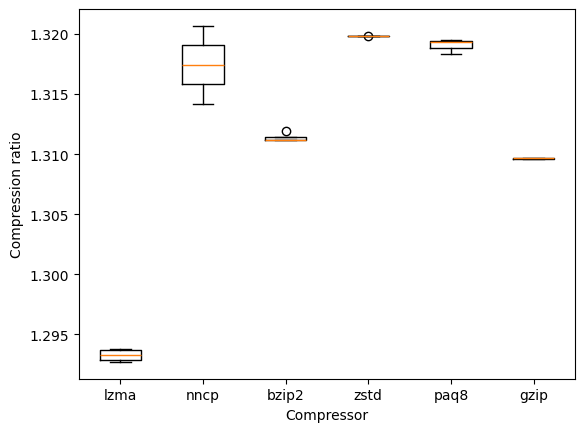

In [9]:
box_plot(df)

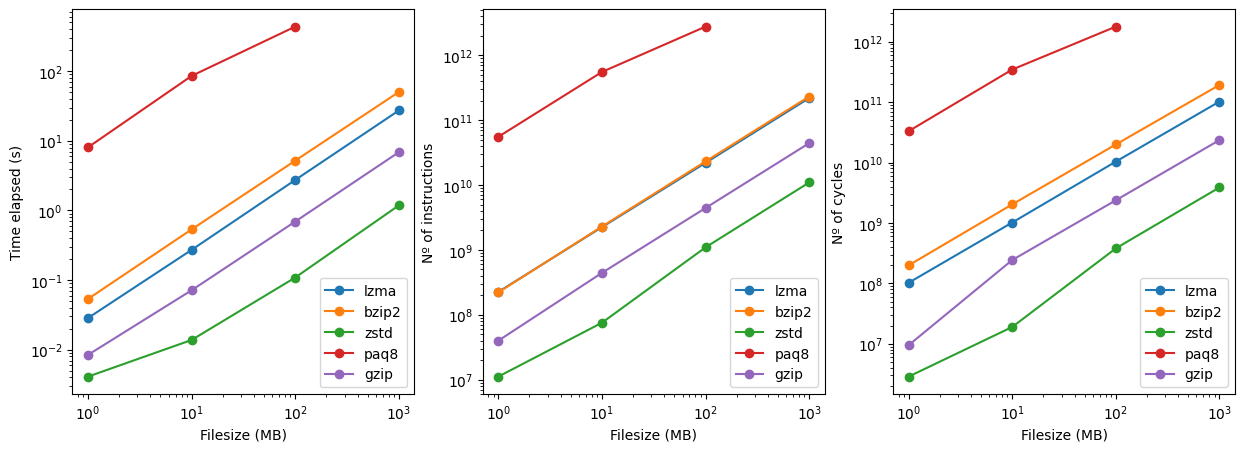

In [15]:
plot_stat(df, decompression=True)

## Text files

In [17]:
df = load_data("text")
df.head()

,task-clock,cycles,instructions,time-elapsed,compressor,filesize,dtask-clock,dcycles,dinstructions,dtime-elapsed,compressed_size
0,381.75,1520910863,1966411607,0.383755,lzma,1Mb,2.10,4450556.0,6345100.0,0.002695,269294.0
1,381.75,1520910863,1966411607,0.383755,lzma,1Mb,1.83,2711916.0,6345102.0,0.002192,269294.0
2,381.75,1520910863,1966411607,0.383755,lzma,1Mb,1.77,4174202.0,6345098.0,0.002121,269294.0
3,381.75,1520910863,1966411607,0.383755,lzma,1Mb,2.09,2339900.0,6345104.0,0.002453,269294.0
4,381.75,1520910863,1966411607,0.383755,lzma,1Mb,2.11,4268685.0,6345121.0,0.002475,269294.0


In [24]:

a = df[df["compressor"] == "zstd"][["filesize", "time-elapsed"]]
# get mean of time-elapsed
df.groupby(["compressor", "filesize"])["time-elapsed"].mean().reset_index()



,compressor,filesize,time-elapsed
0,bzip2,1000Mb,79.778094
1,bzip2,100Mb,7.990286
2,bzip2,10Mb,0.809429
3,bzip2,1Mb,0.083870
4,gzip,1000Mb,40.578712
5,gzip,100Mb,4.094911
6,gzip,10Mb,0.411979
7,gzip,1Mb,0.042798
8,lzma,1000Mb,345.552980
9,lzma,100Mb,33.034846


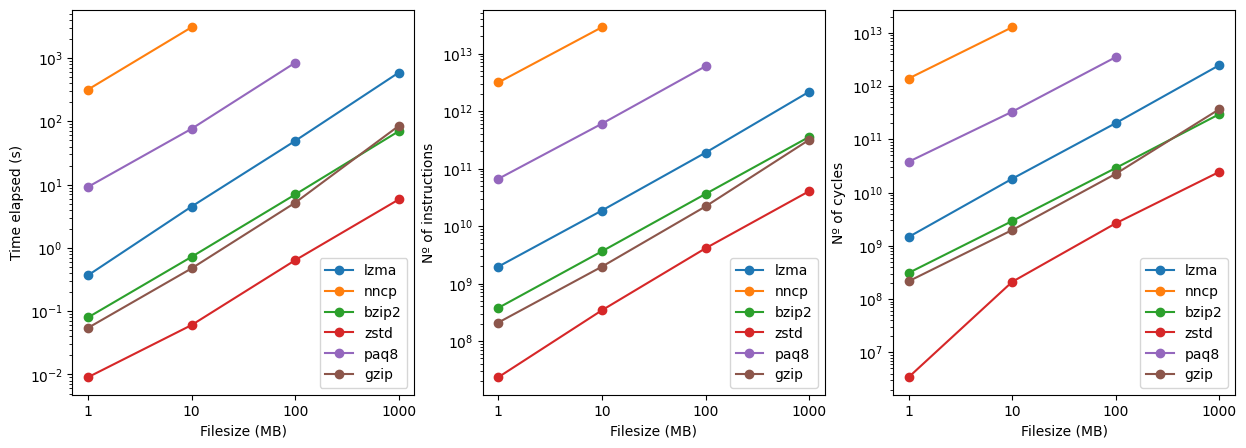

In [36]:
plot_stat(df)

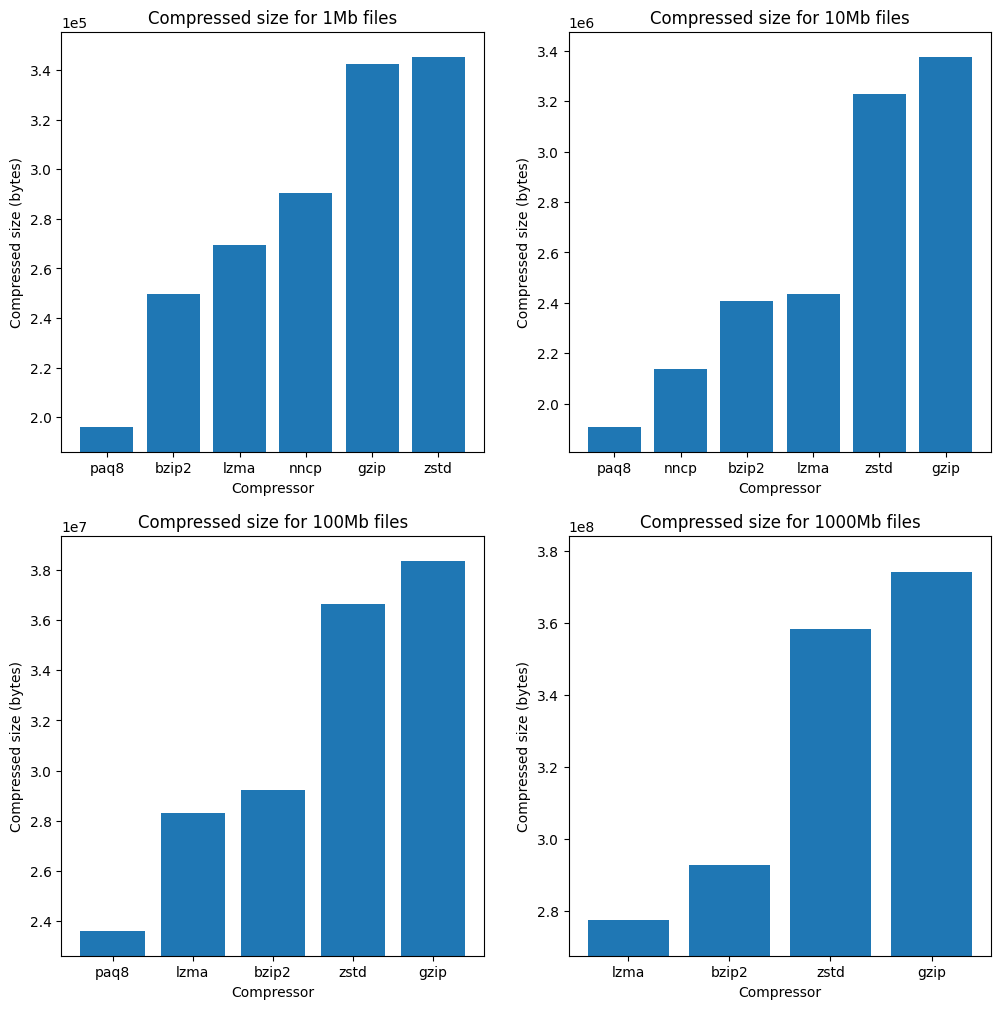

In [37]:
plot_compressed_size(df)

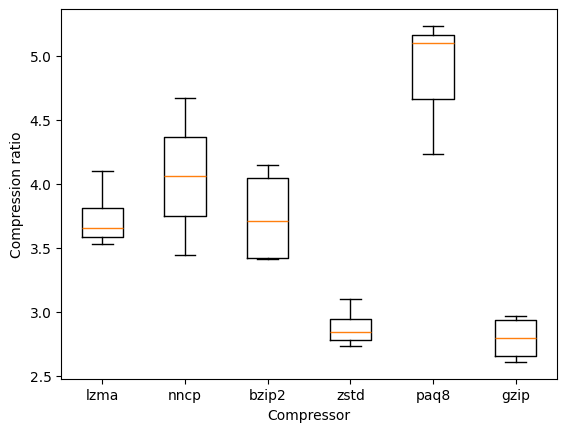

In [38]:
box_plot(df)

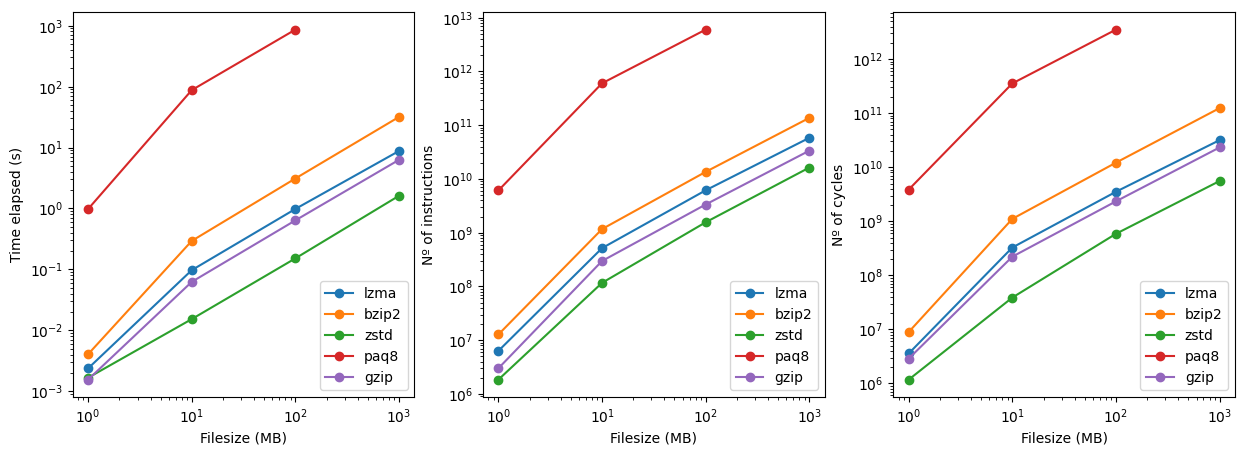

In [18]:
plot_stat(df, decompression=True)

## FASTA

In [6]:
df = load_data("genome/fasta")
df.head()

,task-clock,cycles,instructions,time-elapsed,compressor,filesize,compressed_size
0,267037.25,1078108991239,1447872064143,137.316179,MFCompress,2400Mb,212372755.0
1,279762.21,1124881295437,1447822655111,143.398443,MFCompress,2400Mb,212372755.0
2,281851.26,1129656727065,1447698201260,145.739757,MFCompress,2400Mb,212372755.0
3,287251.67,1144479325673,1448117553185,147.546142,MFCompress,2400Mb,212372755.0
4,287346.88,1147963153458,1447744887108,147.450504,MFCompress,2400Mb,212372755.0


In [7]:
df[df["compressor"]=="gzip"][["filesize", "time-elapsed"]].groupby("filesize").mean()

,time-elapsed
filesize,
1200Mb,99.992024
2400Mb,204.048761
440Mb,62.232706
540Mb,76.420922
60Mb,7.217384


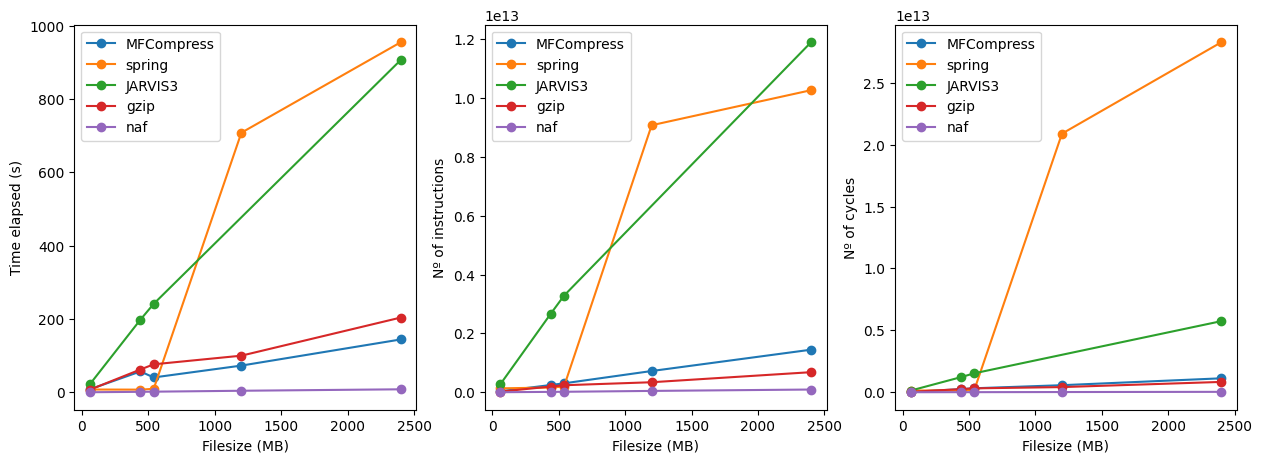

In [8]:
# remove lines with filesize = 3000Mb
df = df[df["filesize"]!="3000Mb"]

plot_stat(df, log=False)

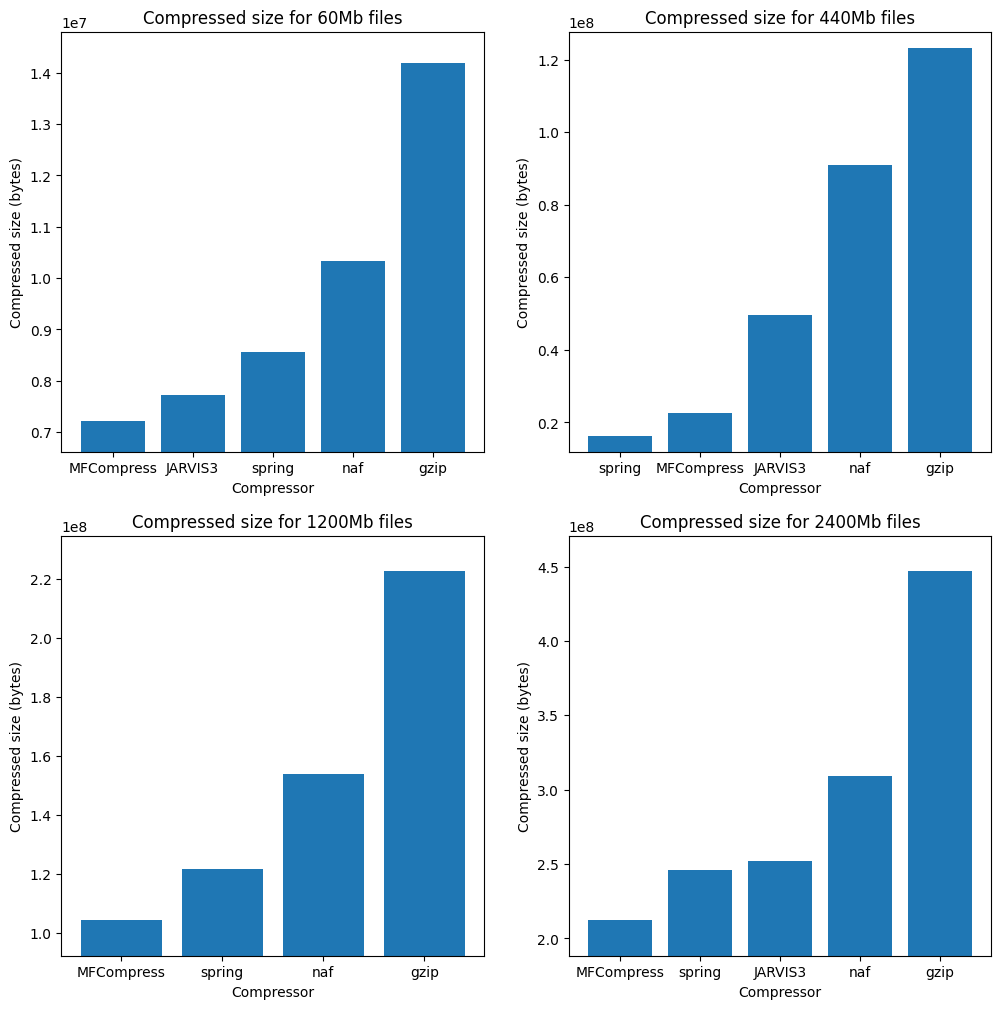

In [10]:
plot_compressed_size(df, filesizes=["60Mb", "440Mb", "1200Mb", "2400Mb"])

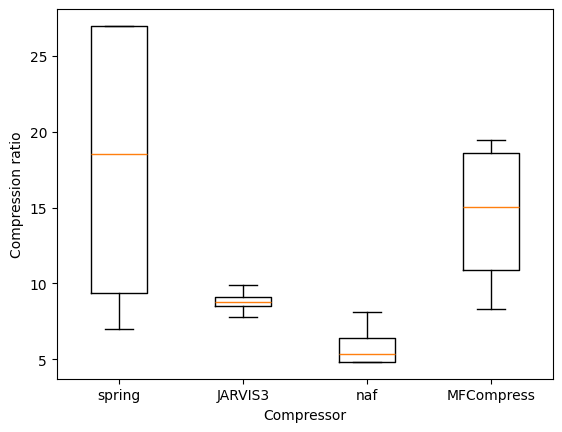

In [35]:
box_plot(df)

In [57]:
tmp = df.groupby(["compressor", "filesize"]).mean().reset_index()
tmp["comp_ratio"] = tmp["filesize"].apply(lambda x: int(x.split("Mb")[0]))/(tmp["compressed_size"]/1_000_000)
tmp[["compressor","filesize", "compressed_size", "comp_ratio"]]

,compressor,filesize,compressed_size,comp_ratio
0,bzip2,1000Mb,292918955.0,3.413914
1,bzip2,100Mb,29246445.0,3.419219
2,bzip2,10Mb,2409251.0,4.150668
3,bzip2,1Mb,25541.0,39.152735
4,gzip,1000Mb,374140978.0,2.672789
5,gzip,100Mb,38359685.0,2.606904
6,gzip,10Mb,3375314.0,2.962687
7,gzip,1Mb,29871.0,33.477286
8,lzma,1000Mb,277652301.0,3.601627
9,lzma,100Mb,28323749.0,3.530606


In [8]:
df["filesize_int"] = df.apply(lambda x: int(x["filesize"].split("Mb")[0]), axis=1)
df.head()


,task-clock,cycles,instructions,time-elapsed,compressor,filesize,compressed_size,filesize_int
0,211.86,818500889,1000166135,0.212468,lzma,1Mb,269294.0,1
1,213.50,820043231,993222189,0.213904,lzma,1Mb,269294.0,1
2,207.37,806574398,1010245843,0.213418,lzma,1Mb,269294.0,1
3,201.90,778012545,1002617143,0.210065,lzma,1Mb,269294.0,1
4,212.24,808854635,1000571938,0.212889,lzma,1Mb,269294.0,1


In [21]:
tmp = df[df["compressor"] == "zstd"][["filesize","time-elapsed","filesize_int"]].groupby("filesize").mean().reset_index()
a,b = np.polyfit(tmp["filesize_int"], tmp["time-elapsed"], 1)
print(a, b)

0.0015045957080673678 0.007396240884288884


In [16]:
df[df["compressor"] == "zstd"][["filesize","time-elapsed"]].groupby("filesize").mean().reset_index()

,filesize,time-elapsed
0,1000Mb,1.511428
1,100Mb,0.163657
2,10Mb,0.021190
3,1Mb,0.004916


In [22]:
for x in [1, 10, 100, 1000]:
    print(a*x + b)

0.008900836592356253
0.022442197964962562
0.15785581169102567
1.5119919489516567


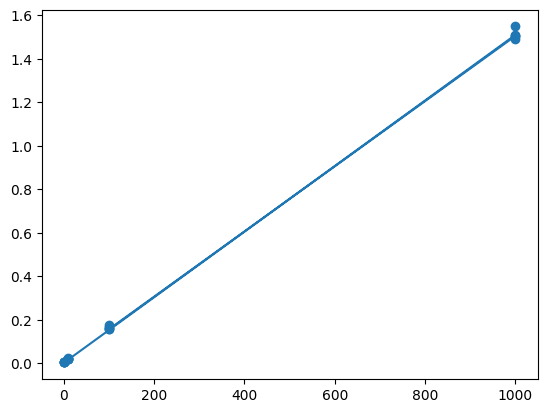

In [18]:
# plot zstd time elapsed
plt.plot(df[df["compressor"] == "zstd"]["filesize_int"], df[df["compressor"] == "zstd"]["time-elapsed"], label="zstd", marker="o")

In [1]:
y = df[df["compressor"] == "zstd"]["time-elapsed"]
y = y.sort_values()
y

NameError: name 'df' is not defined

In [42]:
x = df[df["compressor"] == "zstd"]["filesize_int"]
x = x.sort_values()
x

0       1
0      10
0     100
0    1000
Name: filesize_int, dtype: int64

In [49]:
def exponential_fit(x, a, b, c):
    return a*np.exp(b*x) + c


fitting_parameters, covariance = curve_fit(exponential_fit, x, y)
print(fitting_parameters)
print(covariance)

[1. 1. 1.]
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]


/tmp/ipykernel_8747/435615325.py:2: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x) + c
/tmp/ipykernel_8747/435615325.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  fitting_parameters, covariance = curve_fit(exponential_fit, x, y)


In [48]:
for x in [1, 10, 100, 1000]:
    print(exponential_fit(x, *fitting_parameters))

3.718281828459045
22027.465794806718
2.6881171418161356e+43
inf


/tmp/ipykernel_8747/435615325.py:2: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x) + c


In [46]:
def exponential_fit(x, a, b, c):
    return a*np.exp(b*x) + c


for x in [1, 10, 100, 1000]:
    print(exponential_fit(x, 1, 1, 0))

2.718281828459045
22026.465794806718
2.6881171418161356e+43
inf


/tmp/ipykernel_8747/3851954322.py:2: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x) + c
